In [1]:
import warnings; warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model

In [2]:
TICKERS = ["SPY", "QQQ"]
START = "2021-01-01"         # Since starting from 2021
END = None                   # None = today
ROLL_N = 21
TRAIN_FRAC = 0.6

In [3]:
data = yf.download(TICKERS, start=START, end=END, progress=False)

In [4]:
data

Price            Close                    High                     Low  \
Ticker             QQQ         SPY         QQQ         SPY         QQQ   
Date                                                                     
2021-01-04  300.898254  346.231232  306.715638  352.483845  296.880566   
2021-01-05  303.378937  348.615845  303.651351  349.714289  299.906046   
2021-01-06  299.176453  350.700073  303.398423  353.920283  297.658879   
2021-01-07  306.414032  355.910553  307.250630  356.661606  301.812655   
2021-01-08  310.353912  357.938416  310.704138  358.154328  306.511322   
...                ...         ...         ...         ...         ...   
2025-08-29  570.400024  645.049988  575.030029  647.840027  568.539978   
2025-09-02  565.619995  640.270020  565.969971  640.489990  559.539978   
2025-09-03  570.070007  643.739990  571.700012  644.210022  566.729980   
2025-09-04  575.229980  649.119995  575.599976  649.150024  569.030029   
2025-09-05  576.059998  647.239990  581.119995  652.210022  571.530029   

Price                         Open                Volume             
Ticker             SPY         QQQ         SPY       QQQ        SPY  
Date                                                                 
2021-01-04  342.504074  306.540510  352.352395  45305900  110210800  
2021-01-05  345.536482  299.906046  345.583441  29323400   66426200  
2021-01-06  346.541062  298.651130  347.094968  52809600  107997700  
2021-01-07  352.915682  301.841838  353.094062  30394800   68766800  
2021-01-08  354.032878  308.709870  357.309387  33955800   71677200  
...                ...         ...         ...       ...        ...  
2025-08-29  643.140015  574.659973  647.469971  56030400   74522200  
2025-09-02  634.919983  561.309998  637.500000  65876800   81983500  
2025-09-03  640.460022  569.229980  642.669983  54230200   70820900  
2025-09-04  643.510010  570.739990  644.419983  47526300   65219200  
2025-09-05  643.330017  580.489990  651.479980  68308700   84970600  

[1174 rows x 10 columns]

### From the dataframe, picking the closing price because it is consistent, gives a clean measure of day-to-day return.

In [5]:
px = data['Close'].dropna()
px

Ticker,QQQ,SPY
Date,,
2021-01-04,300.898254,346.231232
2021-01-05,303.378937,348.615845
2021-01-06,299.176453,350.700073
2021-01-07,306.414032,355.910553
2021-01-08,310.353912,357.938416
...,...,...
2025-08-29,570.400024,645.049988
2025-09-02,565.619995,640.270020
2025-09-03,570.070007,643.739990


## EDA

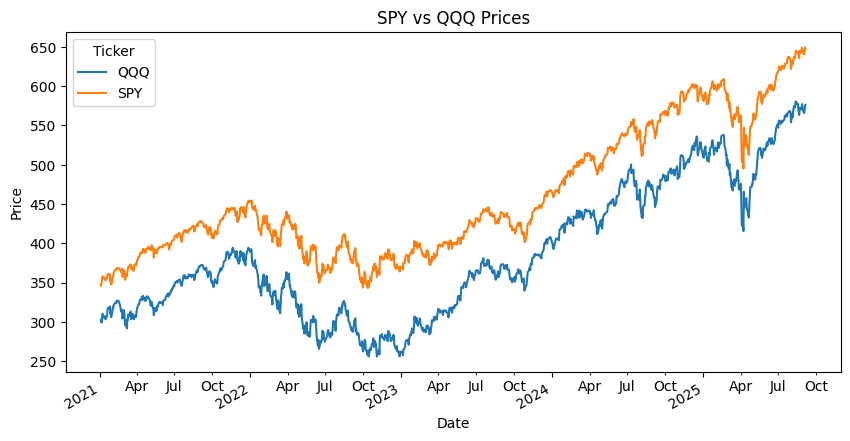

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10,5))
px.plot(ax=ax, title="SPY vs QQQ Prices")
ax.set_ylabel("Price")

# Major ticks = years
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Minor ticks = every 3 months
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

fig.autofmt_xdate()
plt.show()


#### 1. SPY and QQQ are highly correlated, reflecting broad market moves.
#### 2. Noticeable dip in 2022. Recovery starts in 2023, with QQQ showing sharper swings.
#### 3. QQQ tends to be more volatile than SPY (sharper drops/ rebounds)
#### 4. The clear volatility clusters (e.g.- lage swings in 2022, calmer 2023, spike again in 2025) are ideal for GARCH.

GARCH easures volatility of retuens, not prices. Computing returns

In [ ]:
ret = 100*np.log(px/px.shift(1)).dropna()   # percent log-returns
ret.plot(subplots=True, figsize=(10,6), title="Daily Returns (%)")
plt.show()

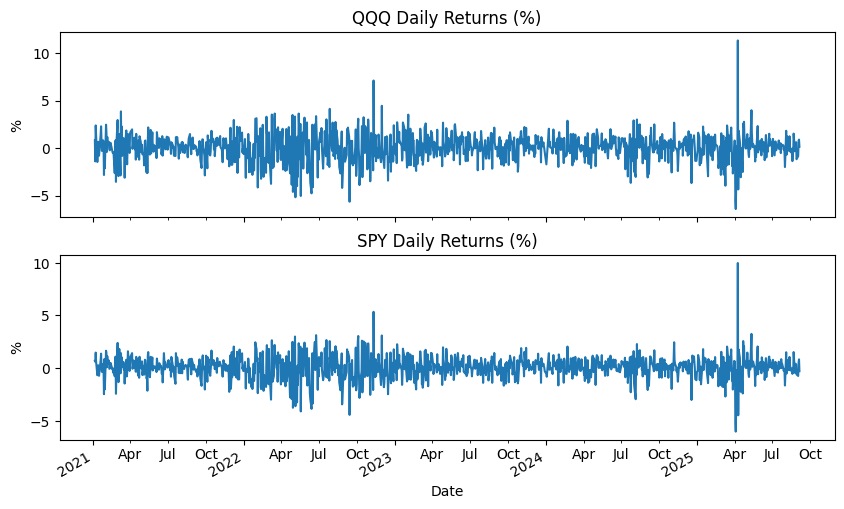

In [8]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(nrows=len(ret.columns), figsize=(10,6), sharex=True)

# Plot each series into its own subplot
for i, col in enumerate(ret.columns):
    ret[col].plot(ax=axes[i], title=f"{col} Daily Returns (%)")
    axes[i].set_ylabel("%")

    # Major ticks = years
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Minor ticks = quarterly (Jan, Apr, Jul, Oct)
    axes[i].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
    axes[i].xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

fig.autofmt_xdate()
plt.show()


Return series looks like white noise (mean near 0, spikes near crises).

#### saying returns look like white noise means direction is unpredictable. Meaning trying to forecast whether SPY will be +0.5% or -0.5% tomorrow, can't do better than a coin flip.

#### White noise = a ransom series with -
#### returns are centered around 0% with lots of noise.
#### (a) mean 0 (no upward or downward drift)
#### (b) constant variance
#### (c) no autocorrelation (today's values tells nothing about tomorrow)


#### But large moves bunch together. It today was volatile, tomorrow is more likely to be volatile.

#### Return themselves are close to white noise (no predictable direction). But their volatility shows clustering.
#### This is why return is not modeled with GARCH; variance of return is modeled.
#### In the plot, the up and down movement of SPY/QQQ return looks random. But the size of the swings is not random as they come in clusters (smallers bursts in 2022, mid-2025)

### Summary statistics

In [9]:
print(ret.describe().T)

# Skewness, kurtosis
from scipy.stats import skew, kurtosis
for tkr in ret.columns:
    print(f"{tkr}: skew={skew(ret[tkr]):.2f}, kurtosis={kurtosis(ret[tkr]):.2f}")


         count      mean       std       min       25%       50%       75%  \
Ticker                                                                       
QQQ     1173.0  0.055366  1.450506 -6.412141 -0.687487  0.106682  0.869472   
SPY     1173.0  0.053334  1.096304 -6.032656 -0.484451  0.068946  0.635294   

              max  
Ticker             
QQQ     11.335614  
SPY      9.986286  
QQQ: skew=0.05, kurtosis=4.39
SPY: skew=0.15, kurtosis=7.91


#### 1173 observations.
#### mean is close to 0.05 indicating returns hover near zero daily.
#### standard deviation indicating that QQQ is more volatile.

#### Kurtosis measures tail heaviness (fat tails VS gaussian)
#### skewness ≈ 0, Kustosis > 3, student-t
#### skewness ≠ 0, Kurtosis > 3, Skewed Student-t
#### Skewness ≈ 0, Kurtosis ≈ 3, Normal (rare in practice for fianncial returns)

### Volatility clustering

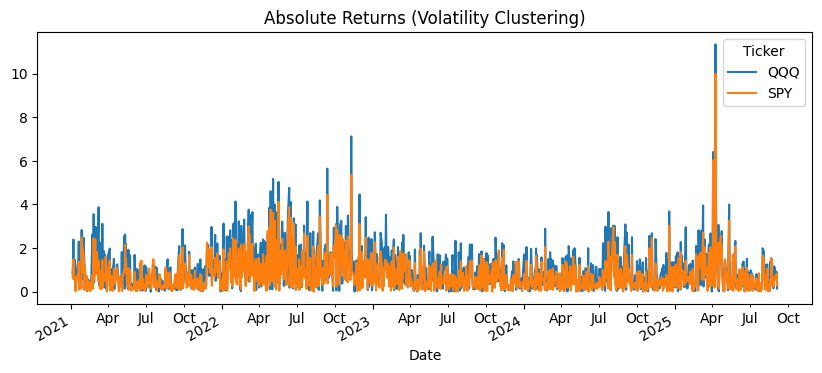

In [10]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10,4))
ret_abs = ret.abs()
ret_abs.plot(ax=ax, title="Absolute Returns (Volatility Clustering)")

# Major ticks = years
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Minor ticks = quarter months (Jan, Apr, Jul, Oct)
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

# Rotate to avoid overlap
fig.autofmt_xdate()
plt.show()


If returns were true white noise, this plot would look like flat (everyday same return). Instead variance changes over time. The series is heteroskedastic.

#### Absolute returns show-
#### (a) calm periods (small moves, low volatility)
#### (b) Turbulent periods (clusters of large swings)

Noticeable spikes in mid-2022. Very large volatility shock in 2025.

### Autocorrelation plots

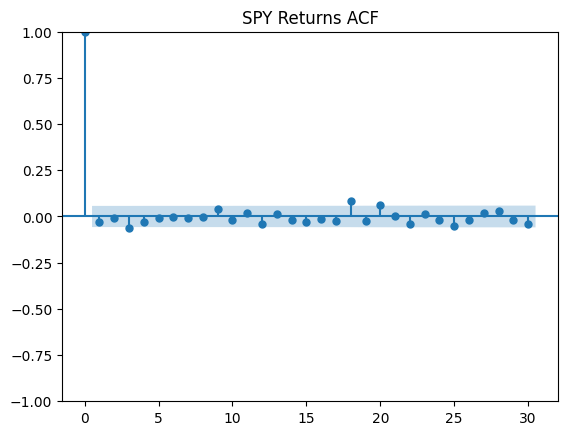

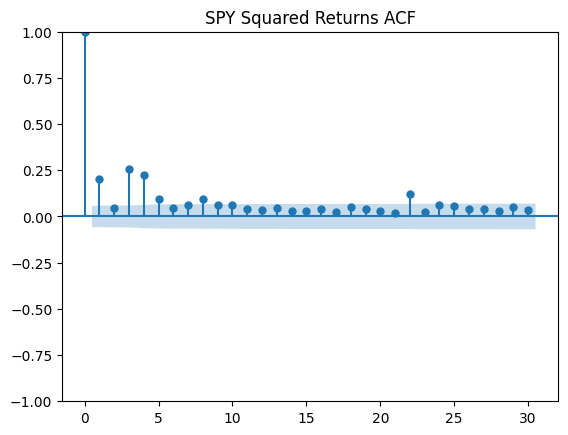

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ret["SPY"], lags=30, title="SPY Returns ACF")
plt.show()
plot_acf(ret["SPY"]**2, lags=30, title="SPY Squared Returns ACF")
plt.show()


almost all bars fall within blue confidence band. That means the correlations are statistically insignificant. cannot predict directions.
for the second plot, at lags 1 to 3 there is significant positive autocorrelation. after that it decays towards 0 but not immediately. Meaning a larger return yesterday makes it more likely that today's return will also be large in magnitude.Volatility is persistent. High volatility tends to follow high volatility.

Applying GARCH model

In [12]:
ret = 100*np.log(px/px.shift(1)).dropna()   # percent log-returns
spy = ret["SPY"].dropna()
qqq = ret["QQQ"].dropna()

In [ ]:
# From the EDA section noticed that using t-distribution is suitable.
def garch_oos_var(r, split_idx, mean="Constant", dist="t"):
    # r: Pandas Series with a DatetimeIndex, no NaNs
    r = r.dropna()
    # Building the model on the full series
    am = arch_model(r, vol="GARCH", p=1, q=1, mean=mean, dist=dist)

    # Using data up to split_idx-1 for parameter estimation; the rest is held out
    last_obs_lbl = r.index[split_idx - 1]
    res = am.fit(last_obs=last_obs_lbl, disp="off")

    # Forecasting 1-step-ahead starting at the first OOS date
    start_lbl = r.index[split_idx]
    fc = res.forecast(horizon=1, start=start_lbl, reindex=True)

    # Extracting 1-step variance ("h.1") on the OOS window
    var_hat = fc.variance["h.1"].reindex(r.index[split_idx:])
    var_hat.name = r.name
    return var_hat


In [ ]:
# from arch import arch_model
# res = arch_model(spy, vol="GARCH", p=1, q=1, mean="Constant", dist="t").fit(disp="off")
# alpha = res.params.get("alpha[1]", np.nan)
# beta  = res.params.get("beta[1]", np.nan)
# print({"alpha": alpha, "beta": beta, "alpha+beta": alpha+beta})
# # If alpha+beta ~ 0.95–0.99 → strong persistence (GARCH helps). If much lower, rolling/EWMA can win.


In [ ]:
split_idx_spy = int(TRAIN_FRAC*len(spy))
split_date_spy = spy.index[split_idx_spy]

# Baseline rolling forecast (1-step ahead)
# Takes the SPY returns series and applies a rolling window of length ROLL_N.
# If ROLL_N = 21, that means each window covers the last 21 trading days
# for each day t, the window contains (t-20, ....., t)
# within each rolling window, computing the sample standard deviation of returns.
# shifting the entire series down by 1 day. The volatility observed on day t is not available until the end of day t. 
# when forecasting volatility at day t, should only use information up to t-1.
 
roll_vol_spy = spy.rolling(ROLL_N).std().shift(1)
roll_var_spy = roll_vol_spy**2

# GARCH(1,1) OOS variance forecast
garch_var_spy = garch_oos_var(spy, split_idx_spy, mean="Constant", dist="t")
garch_vol_spy = np.sqrt(garch_var_spy)

# Align and score (use same OOS window)
realized_var_spy = (spy**2).reindex(garch_var_spy.index) 
# The rolling forecast was made for all the data including OOS.
# But the GRACH forecast was made for OOS
# Reindexing the roll_var_spy to only OOS.

roll_var_spy_oos = roll_var_spy.reindex(garch_var_spy.index) 


In [14]:
def eval_variance_forecast(var_hat, r):
    df = pd.DataFrame({"var_hat": var_hat, "var_real": r**2}).dropna()
    mse_var = np.mean((df.var_hat - df.var_real)**2)
    mae_std = np.mean(np.abs(np.sqrt(df.var_hat) - np.sqrt(df.var_real)))
    qlike   = np.mean(np.log(df.var_hat) + df.var_real/df.var_hat)
    return {"MSE_var": mse_var, "MAE_std": mae_std, "QLIKE": qlike}

In [ ]:
# grach_var_spy is teh forecasted variance from GARCH(1,1) model. 
# r**2 or spy**2 is the realized variance(squared return of the day)
scores_garch_spy = eval_variance_forecast(garch_var_spy, spy.reindex(garch_var_spy.index))
scores_roll_spy  = eval_variance_forecast(roll_var_spy_oos, spy.reindex(garch_var_spy.index))

In [17]:
print("SPY variance forecast scores (lower is better)")
print("GARCH :", scores_garch_spy)
print("Rolling:", scores_roll_spy)

SPY variance forecast scores (lower is better)
GARCH : {'MSE_var': np.float64(22.61301917577496), 'MAE_std': np.float64(0.5563126207824379), 'QLIKE': np.float64(0.5899219458308099)}
Rolling: {'MSE_var': np.float64(28.003203090037076), 'MAE_std': np.float64(0.587068910606405), 'QLIKE': np.float64(0.9072559737139212)}


### Similarly for QQQ

In [18]:
split_idx_qqq = int(TRAIN_FRAC*len(qqq))
garch_var_qqq = garch_oos_var(qqq, split_idx_qqq, mean="Constant", dist="t")
roll_var_qqq  = qqq.rolling(ROLL_N).std().shift(1)**2

scores_garch_qqq = eval_variance_forecast(garch_var_qqq, qqq.reindex(garch_var_qqq.index))
scores_roll_qqq  = eval_variance_forecast(roll_var_qqq.reindex(garch_var_qqq.index), qqq.reindex(garch_var_qqq.index))
print("\nQQQ variance forecast scores (lower is better)")
print("GARCH :", scores_garch_qqq)
print("Rolling:", scores_roll_qqq)



QQQ variance forecast scores (lower is better)
GARCH : {'MSE_var': np.float64(38.14441865388052), 'MAE_std': np.float64(0.730019797167901), 'QLIKE': np.float64(1.2039455433690218)}
Rolling: {'MSE_var': np.float64(46.249849011249594), 'MAE_std': np.float64(0.7592598040256926), 'QLIKE': np.float64(1.4375221480359381)}


## Building a 2-asset risk-parity portfolio (Using GARCH Volatility)

In [23]:
# putting volatility forecast into one frame on the common OOS dates
garch_vol_df = pd.concat(
    [
     np.sqrt(garch_var_spy).rename("SPY"),
     np.sqrt(garch_var_qqq).rename("QQQ")
    ], axis = 1
).dropna()

Forecasted voaltility for tomorrow in known for each day.
Weights each day are inversely proportional to forecasted volatility. Then normalized to sum to 1.

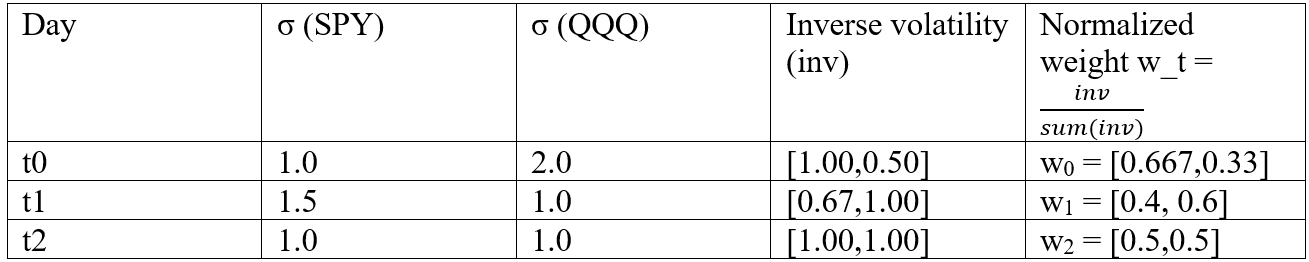

Next-day asset return

#### What is known -
#### 1. Historical returns up to day t.
#### 2. Volatility forecast for day t+1 (from GARCH, rolling etc.)
#### Don't know actual return on day t+1 will be.
#### Computed weights at the end of t. Then apply to the realized return on day t+1 when it happens. This the shift(-1).


#### Example,
#### At the end of Monday,
#### Forecasted volatility: SPY = 1%, QQQ = 2%
#### Risk-parity says weights = [0.67, 0.33]

#### On Tuesday:
#### Actual returns come in: SPY = +0.5%, QQQ = -1.0%
#### Portfolio return for Tuesday = 0.67 * (0.5) + 0.33* (-1.0) = 0.0%
#### Tuesday's return is not known on Monday. Only discover it later which is why next day return.

In [24]:
idx = garch_vol_df.dropna().index
vol = garch_vol_df.reindex(idx)
inv = 1.0/vol
w = inv.div(inv.sum(axis=1), axis =0)

# next day return
r_next = ret[["SPY","QQQ"]].reindex(idx).shift(-1)
#portfolio return for next day
gross = (w*r_next).sum(axis =1).dropna()


After using volatility prediction for t+1, return for t+1, calculated portfolio return for t+1. Now calculate turnover.

Turnover measures how much portfolio wights change from one day to the next. If weights are stable, turnover is low, so few trades. if weights swing around, tirnover is high, so lots of trades.

In [25]:
turn = 0.5 * w.diff().abs().sum(axis=1)

#### For example,
#### yesterday portoflio had weights
#### wt-1 = [0.7,0.3]
#### and today weights became
#### wt = [0.6, 0.4]
#### change = [-0.10,0.10]
#### absolute change =  [0.10,0.10]
#### sum = 0.20
#### Turnover = 05 * 20 = 0.10 (10%)

Every trade costs  money(broker fees, bid-ask spreads, slippage). We model this as a cost per unit turnover.

In [26]:
tc_bps = 0

In [27]:
net = gross - turn *(tc_bps/1000.0) * 1000.0

In [28]:
# Benchmark: equal-weight (daily rebalance)
common_idx = garch_vol_df.index
eq_ret = (0.5*ret["SPY"].reindex(common_idx).shift(-1) +
          0.5*ret["QQQ"].reindex(common_idx).shift(-1)).dropna()

In [29]:
r = net /100.0 # percentag edaily return
mu = r.mean()*252 
sd = r.std() * np.sqrt(252)
sharpe = 0.0 if sd ==0 else mu/sd
curve=(1+r).cumprod()
mdd = (curve/curve.cummax()-1).min()

In [30]:
print('Annret:', mu)
print('AnnVol:', sd)
print("sharpe:", sharpe)
print("MaxDD:", mdd)

Annret: 0.2540029003870588
AnnVol: 0.18278255019711623
sharpe: 1.389645237541205
MaxDD: -0.20999637887468747


In [31]:
r = eq_ret /100.0 # percentag edaily return
mu = r.mean()*252 
sd = r.std() * np.sqrt(252)
sharpe = 0.0 if sd ==0 else mu/sd
curve=(1+r).cumprod()
mdd = (curve/curve.cummax()-1).min()


In [32]:
print('Annret:', mu)
print('AnnVol:', sd)
print("sharpe:", sharpe)
print("MaxDD:", mdd)

Annret: 0.2548641428104681
AnnVol: 0.18615316883041527
sharpe: 1.369109880920954
MaxDD: -0.2131360310284306


#### Both portfolios had nearly identical returns (~25.5%)
#### Risk-parity slightly reduced volatility
#### Risk-parity's sharpe > equal weight's
#### Risk-parity max drawdown = –21.0%, vs –21.3% for equal-weigh